In [1]:
using Plots
using PyCall
using SpecialFunctions
using LinearAlgebra

In [2]:
function GeologicalModel(key_word)
    
    geo = Dict("nx"=>0, "nz"=>0, "dx"=>0, "dz"=>0,
                "cp"=>0, "cs" =>0,"rho" =>0, "lambda" => 0,
                "mu"=>0, "kappa"=>0, "topbc"=>"free", "sidesbc"=>"abbc")

    if key_word == "1"
        
        np = pyimport("numpy")
        
        amostras = 401
        endereco1 = "C:/Users/Matheus/Trabalhos e Estudos/Trabalhos para o mestrado/GeologicalData/toy2023_cp.bin"
        endereco2 = "C:/Users/Matheus/Trabalhos e Estudos/Trabalhos para o mestrado/GeologicalData/toy2023_ro.bin"
        dado1 = np.fromfile(endereco1, dtype="float32")
        dado2 = np.fromfile(endereco2, dtype="float32")
        
        nrecs = Int64(length(dado1) // amostras)
        cp = reshape(dado1, amostras, nrecs)
        rho = reshape(dado2, amostras, nrecs)
        
    end

    geo["cp"] = similar(cp, Float64)
    geo["rho"] = similar(rho, Float64)
    geo["cp"] .= cp
    geo["rho"] .= rho

    geo["dx"] = 5.0
    geo["dz"] = 5.0
    geo["nz"] = size(cp, 1)
    geo["nx"] = size(cp, 2)

    geo["cs"] = geo["cp"] ./ 2
    geo["mu"] = geo["cs"] .* geo["cs"] .* geo["rho"]
    geo["kappa"] = geo["cp"] .* geo["cp"] .* geo["rho"] 
    geo["lambda"] = geo["cp"] .* geo["cp"] .* geo["rho"]  .- 2*geo["mu"]

    return geo
end

GeologicalModel (generic function with 1 method)

In [3]:
function ComputationalParameters(geo)
    
    CP = Dict(
    "bxx" => zeros(Float64, geo["nz"], geo["nx"]),
    "bzz" => zeros(Float64, geo["nz"], geo["nx"]),
    "C" => zeros(Float64, 6, 6, geo["nz"], geo["nx"]),
    "C55" => zeros(Float64, geo["nz"], geo["nx"]))
    
    rho = geo["rho"]
    bzz = zeros(geo["nz"], geo["nx"]) # Variação da densidade na direção z
    bxx = zeros(geo["nz"], geo["nx"]) # Variação da densidade na direção x
    C55 = zeros(geo["nz"], geo["nx"]) 
    C = zeros(6, 6, geo["nz"], geo["nx"]) # Módulos Elástico

    for i in 1:6
        for j in 1:6
            if i == j && i < 4
                C[i, j, :, :] = geo["lambda"] + 2 * geo["mu"]
            elseif i == j && i >= 4
                C[i, j, :, :] = geo["mu"]
            elseif i == 1 && (j == 2 || j == 3)
                C[i, j, :, :] = geo["lambda"] 
            elseif i == 2 && (j == 1 || j == 3)
                C[i, j, :, :] = geo["lambda"] 
            elseif i == 3 && (j == 1 || j == 2)
                C[i, j, :, :] = geo["lambda"] 
            end
        end
    end

    for i in 2:geo["nz"]
        for k in 2:geo["nx"]
            bzz[i,k] = 0.5 * (1/rho[i - 1, k] + 1/rho[i, k])
            bxx[i,k] = 0.5 * (1/rho[i, k - 1] + 1/rho[i, k])
            C55[i,k] = (0.25*(1/C[5,5,i,k] + 1/C[5,5,i-1,k] + 1/C[5,5,i,k] + 1/C[5,5,i,k-1]))^(-1)
        end
    end

    CP["C"] .+= C
    CP["C55"] .+= C55
    CP["bxx"] .+= bxx
    CP["bzz"] .+= bzz
    
    return CP
end

ComputationalParameters (generic function with 1 method)

In [4]:
function wavelet(f_corte, t)

    f_c = f_corte/(3*sqrt(pi))
    t_0 = (2*sqrt(pi))/f_corte
    t_d = t .- t_0

    src = -(2*pi^3 .*(f_c .*t_d).^2 .- 1) .* exp.(-(pi^3 .*(f_c .*t_d).^2))
    return src

end

wavelet (generic function with 1 method)

In [5]:
function CerjanCondition(a0, iabmax)

    eponge = zeros(iabmax + 2)
    eponge[1:iabmax + 1] .= exp.(-((a0/iabmax) .* (iabmax .- collect(0:iabmax))) .^ 2)

    return eponge
end

CerjanCondition (generic function with 1 method)

In [6]:
function ElasticPropagator(txx, tzz, txz, vx, vz, dt, c1, model_geological, eponge, iabmax, aqui, CP)

    # Coeficientes da aproximção por diferenças finitas

    g1 = -1/24
    g2 = 9/8

    # Característica do meio e aquisição

    dx = model_geological["dx"]
    dz = model_geological["dz"]
    nx = model_geological["nx"]
    nz = model_geological["nz"]

    ixs = aqui["isx"]
    izs = aqui["isz"]
    source = aqui["source"]
    topbc = model_geological["topbc"]
    sidesbc = model_geological["sidesbc"]

    isoType = aqui["isoType"]

    C = CP["C"]
    bxx = CP["bxx"]
    bzz = CP["bzz"]
    C55 = CP["C55"]
    
    exx = zeros(Float64,nz+2, nx+2)
    ezz = zeros(Float64,nz+2, nx+2)
    exz = zeros(Float64,nz+2, nx+2)

    soufac = dt / (dx * dz)
    dtdx = dt/dx

    epongex = ones(iabmax+2, nx+2)
    epongez = ones(nz+2, iabmax+2)

    for i in 1:nx
        epongex[1:iabmax+1, i] .= eponge[1:iabmax+1]
    end

    for i in 1:nz
        epongez[i,1:iabmax+1] .= eponge[1:iabmax+1]
    end

    i = 3:nx-1
    k = 3:nz-1

    vx[k, i] .= vx[k, i] .+ dtdx * bxx[k, i] .* (
        g1 .* (txx[k, i .+ 1] .- txx[k, i .- 2]) .+ g2 .* (txx[k, i] .- txx[k, i .- 1]) .+
        g1 .* (txz[k .+ 2, i] .- txz[k .- 1, i]) .+ g2 .* (txz[k .+ 1, i] .- txz[k, i]))

    vz[k, i] .= vz[k, i] .+ dtdx * bzz[k, i] .* (
        g1 .* (txz[k, i .+ 2] .- txz[k, i .- 1]) .+ g2 .* (txz[k, i .+ 1] .- txz[k, i]) .+
        g1 .* (tzz[k .+ 1, i] .- tzz[k .- 2, i]) .+ g2 .* (tzz[k, i] .- tzz[k .- 1, i]))
    
   # Campo de velocidade nas extremidades laterais do modelo
    
    vx[2,i] .= vx[2,i] .+ dtdx .* bxx[2, i].*(
            g1*(txx[2, i.+1].-txx[2, i.-2]) .+ g2.*(txx[2, i].-txx[2, i.-1]).+ 
            g1.*(txz[4, i].-txz[1, i]) .+ g2.*(txz[3, i].-txz[2, i])
                                            )
    
    
    vz[k,2] .= vz[k,2] .+ dtdx .* bzz[k, 2].*(
        g1.*(txz[k,4].-txz[k,1]) .+ g2.*(txz[k,3].-txz[k,2]).+ 
        g1.*(tzz[k.+1,2].-tzz[k.-2,2]) .+ g2.*(tzz[k,2].-tzz[k.-1,2])
                                            )

     # Absorbing boundary conditions (left and right)
    if sidesbc == "abbc"
        ia = 1:iabmax   
        vx[1:nz, ia] .= vx[1:nz, ia] .* epongez[1:nz, ia]
        vz[1:nz, ia] .= vz[1:nz, ia] .* epongez[1:nz, ia]
        vx[1:nz, nx .- ia .- 1] .= vx[1:nz, nx .- ia .- 1] .* epongez[1:nz, ia]
        vz[1:nz, nx .- ia .- 1] .= vz[1:nz, nx .- ia .- 1] .* epongez[1:nz, ia]
    end

    # Absorbing boundary conditions (top and bottom)
    ka = 1:iabmax
    if topbc == "abbc"
        vx[ka, 1:nx] .= vx[ka, 1:nx] .* epongex[ka, 1:nx]
        vz[ka, 1:nx] .=  vz[ka, 1:nx] .* epongex[ka, 1:nx]
    end
    vx[nz .- ka .- 1, 1:nx] .= vx[nz .- ka .- 1, 1:nx] .* epongex[ka, 1:nx]
    vz[nz .- ka .- 1, 1:nx] .= vz[nz .- ka .- 1, 1:nx] .* epongex[ka, 1:nx]
    
    # Condição de superfície livre
    if topbc == "free"
        il = 3:nx-1
        im = 2:nx-1
        vx[1, il] .= vx[1, il] .+ bxx[1,il] .* (g1 .* (txx[1, il .+ 1] .- txx[1, il .- 2]) +
                                        g2 .* (txx[1, il] .- txx[1, il .- 1]) +
                                        g1 .* (txz[3, il] .+ txz[2, il]) +
                                        g2 .* (txz[2, il] .- txz[1, il]))

        vz[1, im] .= vz[1, im] .+ 2 * bzz[1, im] .* (g1 .* tzz[2, im] + g2 .* tzz[1, im])
        vz[2, im] .= vz[2, im] .+ bzz[1, im] .* (g1 .* (tzz[3, im] .+ tzz[1, im]) +
                                       g2 .* (tzz[2, im] .- tzz[1, im]) +
                                       g1 .* (txz[2, im .+ 2] .- txz[2, im .- 1]) +
                                       g2 .* (txz[2, im .+ 1] .- txz[2, im]))
    end
    
    # Adicionando fonte
    if isoType == 4
        adds = 0.5 .* soufac .* source[c1] ./ rho
        vx[izs, ixs] .= vx[izs, ixs] .+ adds
        vx[izs + 1, ixs] .= vx[izs + 1, ixs] .+ adds
    end

    if isoType == 3
        adds = 0.5 .* soufac .* source[c1] ./ rho
        vz[izs + 1, ixs - 1] .= vz[izs + 1, ixs - 1] .+ adds
        vz[izs + 1, ixs] .= vz[izs + 1, ixs] .+ adds
    end
    
    ib = 2:nx-1

    exx[k,ib] .= g1 .* (vx[k, ib .+ 2] .- vx[k, ib .- 1]) .+ g2 .* (vx[k, ib .+ 1] .- vx[k, ib])
    ezz[k,ib] .= g1 .* (vz[k .+ 2, ib] .- vz[k .- 1, ib]) .+ g2 .* (vz[k .+ 1, ib] .- vz[k, ib])
    
    exz[k,2] .= g1.*(vx[k .+ 1, 2] .- vx[k .- 2, 2]) .+ g2.*(vx[k, 2].-vx[k .- 1, 2]) .+ vz[k, 2] .- vz[k, 1] 
    exz[k,ib .+ 1] .= g1 .* (vx[k .+ 1, ib .+ 1] .- vx[k .- 2, ib .+ 1]) .+ g2 .* (vx[k, ib .+ 1] .- vx[k .- 1, ib .+ 1]) .+
              g1 .* (vz[k, ib .+ 1 .+ 1] .- vz[k, ib .- 2 .+ 1]) .+ g2 .* (vz[k, ib .+ 1] .- vz[k, ib .- 1 .+ 1])

    exz[nz-1,2] = vx[nz-1 ,2] - vx[nz-1-1, 2] + vz[nz-1, 2] - vz[nz-1, 2]
    exz[nz-1,ib .+ 1] .= vx[nz-1,ib .+ 1] .- vx[nz-1,ib .+ 1] .+ (g1.*(vz[nz-1, ib .+ 1 .+ 1] .- vz[nz-1,ib .- 2 .+ 1]) .+ 
                                                                g2.*(vz[nz-1,ib .+ 1] .- vz[nz-1,ib .- 1 .+ 1]))        

    txx[k, ib] .= txx[k, ib] .+ dtdx .* (C[1,1,k,ib] .* exx[k,ib] .+  C[1,3,k,ib] .* ezz[k,ib])
    tzz[k, ib] .= tzz[k, ib] .+ dtdx .* (C[3,1,k,ib] .* exx[k,ib] .+  C[3,3,k,ib] .* ezz[k,ib])
    txz[k, ib] .= txz[k, ib] .+ dtdx .* C55[k, ib] .* exz[k,ib]
    
    # Condição de superfície livre
    if topbc == "free"
        
        il = 3:nx-1
        im = 2:nx
        iq = 2:nx

        txz[1, il] .= 0
        txz[2, il] .= txz[2, il] .+ dtdx .* C55[2,il] .* (g1 .* (vx[3, il] .+ vz[1, il.-1] .- vz[1,il] .- vx[1,il]) .+ 
                                 g2 .* (vx[2, il] .- vx[1,il]) .+ 
                                 g1 .* (vz[2,il.+1] .- vz[2,il.-2]) .+ 
                                 g2 .* (vz[2, il] .- vz[2, il.-1]))

        tzz[1, im] .= tzz[1, im] .+ dtdx .* C[3,1,1,im] .* (g1 .* (vx[1,im.+2] .- vx[1,im.-1]) .+ g2 .* (vx[1, im.+1] .- vx[1,im])) .+ 
                       dtdx .* C[3,3,1,im] .* (vz[2, im] .- vz[1, im])

        tzz[2, im] .= tzz[2, im] .+ dtdx .* C[3,1,2,im] .* (g1 .* (vx[2, im.+2] .- vx[2, im.-1]) .+ g2 .* (vx[2, im.+1] .- vx[2, im])) .+ 
                       dtdx .* C[3,3,2,im] .* (g1 .* (vz[4, im] .- vz[1,im]) .+ g2 * (vz[3, im] .- vz[2, im]))

        txx[1, iq] .= txx[1, iq] .+ dtdx .* C[1,1,1,iq] .* (g1 .* (vx[1, iq.+2] .- vx[1, iq.-1]) .+ g2 .* (vx[1,iq.+1] .- vx[1, iq])) .+ 
                       dtdx .* C[1,3,1,iq] .* (vz[2, iq] .- vz[1, iq])

        txx[2, iq] .= txx[2, iq] .+ dtdx .* C[1,1,2,iq] .* (g1.* (vx[2, iq.+2] .- vx[2, iq.-1]) .+ g2 .* (vx[2, iq.+1] .- vx[2, iq])) .+ 
                       dtdx .* C[1,3,2,iq] .* (g1 .* (vz[4, iq] .- vz[1, iq]) .+ g2 .* (vz[3, iq] .- vz[2, iq]))       
    end
    
    # Condição de absorção de borda (esquerda e direita)
    if sidesbc == "abbc"
        ia = 1:iabmax
        tzz[1:nz, ia].= tzz[1:nz, ia].*epongez[1:nz, ia]
        txx[1:nz, ia].= txx[1:nz, ia].*epongez[1:nz, ia]
        txz[1:nz, ia].= txz[1:nz, ia].*epongez[1:nz, ia]
        txx[1:nz, nx .-1 .-ia].=txx[1:nz, nx .-1 .-ia].*epongez[1:nz, ia]
        txz[1:nz, nx .-1 .-ia].=txz[1:nz, nx .-1 .-ia].*epongez[1:nz, ia]
    end

    # Condição de absorção de borda (superior e inferior)
    if topbc == "abbc"
        txx[ka, 1:nx].= txx[ka, 1:nx].*epongex[ka, 1:nx]
        tzz[ka, 1:nx].= tzz[ka, 1:nx].*epongex[ka, 1:nx]
        txz[ka, 1:nx].= txz[ka, 1:nx].*epongex[ka, 1:nx]
    end
    txx[nz .- ka .- 1, 1:nx].=txx[nz .- ka .- 1, 1:nx].*epongex[ka, 1:nx]
    txz[nz .- ka .- 1, 1:nx].=txz[nz .- ka .- 1, 1:nx].*epongex[ka, 1:nx]
    
    # Adicionando o termo fonte
    if isoType == 1
        adds = soufac * source[c1] * 0.25
        adds_matrix = fill(adds, (2, 2))
        txx[izs:izs+1,ixs-1:ixs] .+= adds_matrix
        tzz[izs:izs+1, ixs-1:ixs] .+= adds_matrix
    end
    
    return txx, tzz, txz, vx, vz
end

ElasticPropagator (generic function with 1 method)

In [7]:
function WavePropagator(key_word, nt, dt, geo, eponge, iabmax, aqui, CP)

    irx = aqui["irx"]
    irz = aqui["irz"]
    nrec = length(aqui["irx"])

    SismP = zeros(Float64, nt, nrec)
    SismVx = zeros(Float64, nt, nrec)
    SismVz = zeros(Float64, nt, nrec)

    snap1 = 50
    snapRate = 50
    snapTimes = snap1:snapRate:nt
    pSnap = zeros(Float64, geo["nz"],  geo["nx"], length(snapTimes))
    
    eps = 1/24 + 9/8
    if maximum(geo["cp"])*dt/geo["dx"] <= 1/eps

        println("Critério de estabilidade obedecido")

        vx = zeros(Float64,geo["nz"]+2, geo["nx"]+2)
        vz = zeros(Float64,geo["nz"]+2, geo["nx"]+2)
        txx = zeros(Float64,geo["nz"]+2, geo["nx"]+2)
        tzz = zeros(Float64,geo["nz"]+2, geo["nx"]+2)
        txz = zeros(Float64,geo["nz"]+2, geo["nx"]+2)

        for c1 in 1:nt
            
            txx, tzz, txz, vx, vz = ElasticPropagator(txx, tzz, txz, vx, vz, dt, c1, geo, eponge, iabmax, aqui, CP)

            for i in 1:length(irx)
                SismP[c1, i] = 0.5 * (txx[irz, irx[i]] + tzz[irz, irx[i]])
                SismVx[c1, i] = vx[irz,irx[i]]
                SismVz[c1, i] = vz[irz,irx[i]]
            end
            
            if c1 in snapTimes
                snapIdx = findall(isequal(c1), snapTimes)[1]
                pSnap[:, :, snapIdx] .= 0.5 * (txx[1:nz, 1:nx] + tzz[1:nz, 1:nx])
            end
        end
    else
        println("Critério de estabilidade não obedecido")
    end
    return pSnap, SismP, SismVx, SismVz
end

WavePropagator (generic function with 1 method)

In [8]:
# Criando o modelo geológico 

key_word_geo = "1"
model_geological = @time GeologicalModel(key_word_geo)
println("Modelo geológico criado")

  8.902350 seconds (874.84 k allocations: 88.121 MiB, 0.32% gc time, 44.14% compilation time: <1% of which was recompilation)
Modelo geológico criado


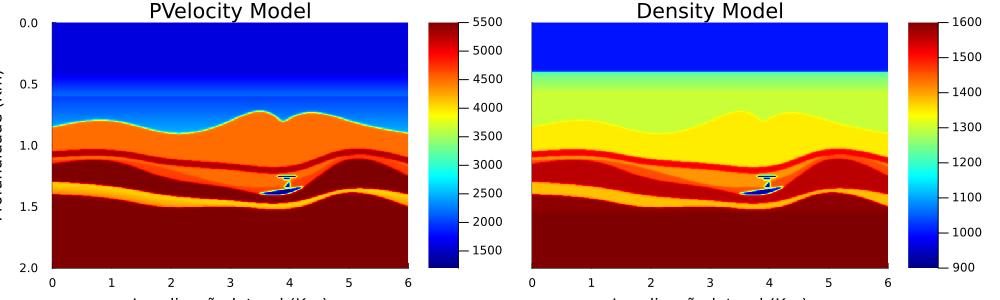

In [9]:
nx = model_geological["nx"]
nz = model_geological["nz"]
dx = model_geological["dx"]
dz = model_geological["dz"]

x = (0:dx:(nx-1)*dx)/1000
z = (0:dz:dz*(nz-1))/1000

p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["cp"],
    axis=:on, color=:auto,c=:jet, title="PVelocity Model", yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")

p2 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["rho"], 
    axis=:on, color=:auto,c=:jet, title="Density Model", yflip=true, xlabel="Localização lateral (Km)", yticks=false)

plot(p1, p2, layout=(1,2), size=(1000, 300))

In [10]:
# Criando a assinatura sísmica (Pulso de Ricker)

dt = 0.0005
nt = 2000
t = 0:dt:nt*dt
f_corte = 48

source = wavelet(f_corte, t)
println("Wavelet Computada")

Wavelet Computada


In [11]:
# Computando as condição de Borada de Cerjan

a0 = 0.2
iabmax = 40
eponge = @time CerjanCondition(a0, iabmax)
println("Condição de absorção de Cerjan definida")

  0.209448 seconds (228.96 k allocations: 15.470 MiB, 99.98% compilation time)
Condição de absorção de Cerjan definida


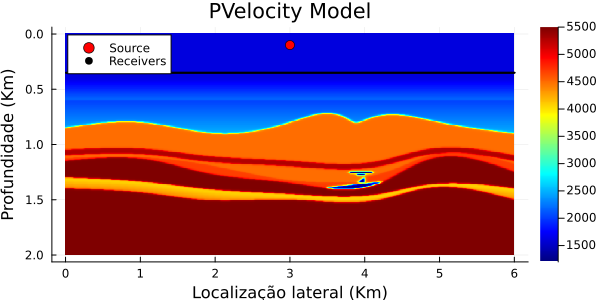

In [12]:
# Característica da aquisição
aqui = Dict("isz" => 20, "irz" => 70, "isx" => 600, "irx" => 1:1:model_geological["nx"], "isoType" => 1, "source" => source)

p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["cp"],
    axis=:on, color=:auto,c=:jet, title="PVelocity Model", yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")
scatter!([dx*aqui["isx"]/1000], [dz*aqui["isz"]/1000], color=:red, markersize=5, label="Source")
scatter!([dx*aqui["irx"]/1000], [dz*aqui["irz"]/1000], color=:black, markersize=1, label="Receivers")
plot(p1, layout=(1,2), size=(600, 300))

In [13]:
# Computando parametros computacionais
CP = @time ComputationalParameters(model_geological)
println("Parâmetros computacionais criados")

  8.755114 seconds (18.41 M allocations: 728.398 MiB, 7.30% gc time, 51.04% compilation time)
Parâmetros computacionais criados


In [14]:
# Propagando a wavelet usando o método das diferenças finitas

num_dataset = 1
key_word_wave = "Elastic"

pSnap, SismP, SismVx, SismVz = @time WavePropagator(key_word_wave, nt, dt, model_geological, eponge, iabmax, aqui, CP)
println("Finish propagation")

Critério de estabilidade obedecido
425.920498 seconds (60.92 M allocations: 400.933 GiB, 12.34% gc time, 3.59% compilation time)
Finish propagation


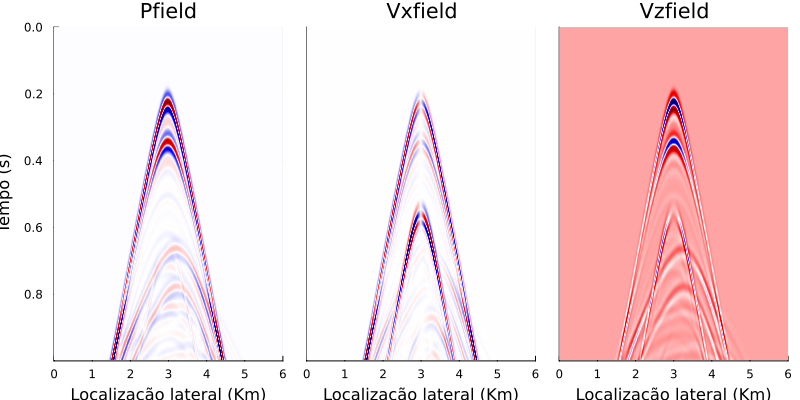

In [15]:
p1 = heatmap(range(x[1], stop=x[end], length=length(x)), range(t[1], stop=t[end-1], length=length(t)-1),
    SismP, axis=:on, color=:auto, colorbar=false,c=:seismic, title="Pfield", yflip=true, 
    xlabel="Localização lateral (Km)", ylabel="Tempo (s)")

p2 = heatmap(range(x[1], stop=x[end], length=length(x)), range(t[1], stop=t[end-1], length=length(t)-1),
    SismVx, axis=:on, color=:auto, colorbar=false,c=:seismic, title="Vxfield", yflip=true, yticks=false,
    xlabel="Localização lateral (Km)")

p3 = heatmap(range(x[1], stop=x[end], length=length(x)), range(t[1], stop=t[end-1], length=length(t)-1),
    SismVz, axis=:on, color=:auto, colorbar=false, c=:seismic, title="Vzfield", yflip=true, yticks=false,
    xlabel="Localização lateral (Km)")

plot(p1, p2, p3, layout=(1,3), size=(800, 400))

[ Info: Saved animation to C:\Users\Matheus\Pictures\DadosModelagens\Resultados\PfieldsElasticWaveHeterogenius.gif


Plots.AnimatedGif("C:\\Users\\Matheus\\Pictures\\DadosModelagens\\Resultados\\PfieldsElasticWaveHeterogenius.gif")
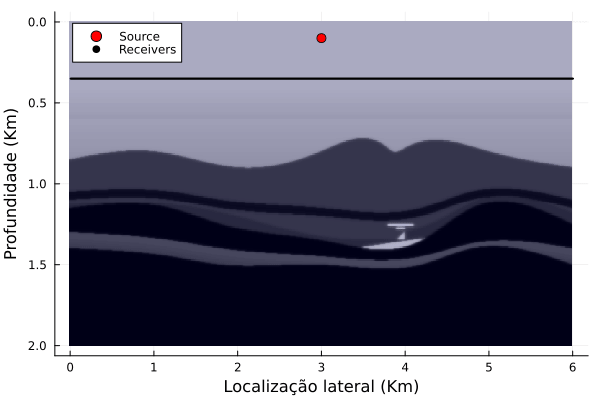

In [16]:
anim = @animate for c1 in 1:1:40
    heatmap(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), pSnap[:,:,c1],
            c=:seismic, colorbar=false, clim=(minimum(pSnap[:,:,15]), maximum(pSnap[:,:,15])),
            yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")
    
    # Plotagem dos dados modelados com transparência ajustada
    heatmap!(range(x[1], stop=x[end], length=length(x)), range(z[1], stop=z[end], length=length(z)), model_geological["cp"]/10^11,
            alpha=0.7, axis=:on, color=:auto, c=:Greys, colorbar=false, clim=(minimum(model_geological["cp"]/10^11), maximum(model_geological["cp"]/10^11)), 
            yflip=true, xlabel="Localização lateral (Km)", ylabel="Profundidade (Km)")
    
    # Plotagem dos pontos de interesse (source e receivers)
    scatter!([dx*aqui["isx"]/1000], [dz*aqui["isz"]/1000], color=:red, markersize=5, label="Source")
    scatter!([dx*aqui["irx"]/1000], [dz*aqui["irz"]/1000], color=:black, markersize=1, label="Receivers")
end

gif(anim, "C:/Users/Matheus/Pictures/DadosModelagens/Resultados/PfieldsElasticWaveHeterogenius.gif", fps=20, loop=0, variable_palette=false, verbose=false, show_msg=true)